In [1]:
import h5py
import numpy as np

from llama.load_test_data import load_cSAXS_data, load_downsampled_cSAXS_data
from llama.api.options.projections import ProjectionOptions
from llama.api.options.task import AlignmentTaskOptions
from llama.task import LaminographyAlignmentTask
from llama.projections import ComplexProjections, PhaseProjections
import llama.image_processing as ip
from llama.plotting import plotters
import llama.gpu_utils as gutils

import matplotlib.pyplot as plt
reconstruction_colormap = "bone"

gutils.turn_off_fft_cache()

In [14]:
complex_projections, angles = load_cSAXS_data()
# complex_projections, angles = load_downsampled_cSAXS_data(8)

In [15]:
# # Sort inputs
# idx_sort = np.argsort(angles)
# angles = angles[idx_sort]
# complex_projections = complex_projections[idx_sort]

projection_options = ProjectionOptions()
complex_projections = ComplexProjections(complex_projections, angles, projection_options)
complex_projections.pin_projections()

task_options = AlignmentTaskOptions()
task = LaminographyAlignmentTask(complex_projections, task_options)

In [16]:
from llama.api.options.device import GPUOptions
from llama.api.enums import DeviceType
task_options.cross_correlation.iterations = 10
task_options.cross_correlation.device.device_type=DeviceType.GPU
n_gpus = 1
task_options.cross_correlation.device.gpu = GPUOptions(
    chunking_enabled=True,
    chunk_length=20,
    n_gpus=n_gpus,
    gpu_indices=[i for i in range(n_gpus)],
)

crop_range = 32 * 30
# crop_range = 128
task_options.cross_correlation.crop_options.enabled = True
task_options.cross_correlation.crop_options.horizontal_range = crop_range
task_options.cross_correlation.crop_options.vertical_range = crop_range

In [17]:
task.get_cross_correlation_shift()
# task.apply_staged_shift()

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Cross-correlation shift stored in shift_history


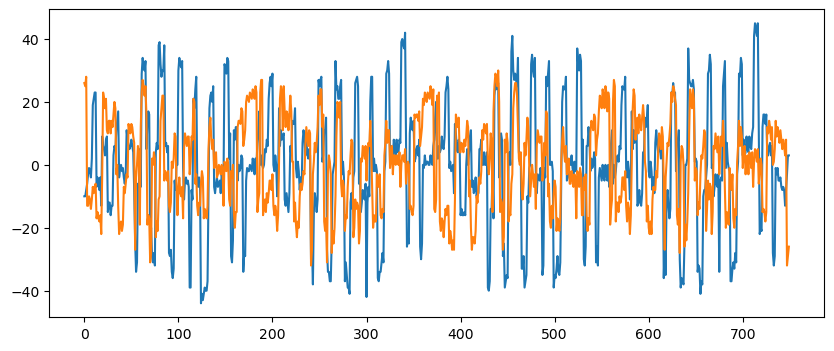

In [19]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(task.shift_manager.staged_shift[np.argsort(angles)])

In [ ]:
import cupy as cp
for i in range(10):
    print("Device num:", i, "Bus ID:", cp.cuda.Device(i).attributes['PciBusId'])

Device num: 0 Bus ID: 8
Device num: 1 Bus ID: 4
Device num: 2 Bus ID: 5
Device num: 3 Bus ID: 6
Device num: 4 Bus ID: 7
Device num: 5 Bus ID: 11
Device num: 6 Bus ID: 12
Device num: 7 Bus ID: 13
Device num: 8 Bus ID: 14
Device num: 9 Bus ID: 15


In [ ]:
cp.cuda.Device(i).attributes

{'AsyncEngineCount': 2,
 'CanFlushRemoteWrites': 0,
 'CanMapHostMemory': 1,
 'CanUseHostPointerForRegisteredMem': 1,
 'ClockRate': 1620000,
 'ComputeMode': 0,
 'ComputePreemptionSupported': 1,
 'ConcurrentKernels': 1,
 'ConcurrentManagedAccess': 1,
 'CooperativeLaunch': 1,
 'CooperativeMultiDeviceLaunch': 1,
 'DirectManagedMemAccessFromHost': 0,
 'EccEnabled': 0,
 'GPUDirectRDMAFlushWritesOptions': 1,
 'GPUDirectRDMASupported': 0,
 'GPUDirectRDMAWritesOrdering': 0,
 'GlobalL1CacheSupported': 1,
 'GlobalMemoryBusWidth': 352,
 'GpuOverlap': 1,
 'HostNativeAtomicSupported': 0,
 'HostRegisterReadOnlySupported': 1,
 'HostRegisterSupported': 1,
 'Integrated': 0,
 'IsMultiGpuBoard': 0,
 'KernelExecTimeout': 0,
 'L2CacheSize': 2883584,
 'LocalL1CacheSupported': 1,
 'ManagedMemory': 1,
 'MaxBlockDimX': 1024,
 'MaxBlockDimY': 1024,
 'MaxBlockDimZ': 64,
 'MaxBlocksPerMultiprocessor': 32,
 'MaxGridDimX': 2147483647,
 'MaxGridDimY': 65535,
 'MaxGridDimZ': 65535,
 'MaxPitch': 2147483647,
 'MaxRegist

In [ ]:
i = 4
print([mem * 1e-6 for mem in cp.cuda.Device(i).mem_info])
32806.40409- 34089.926655999996

[11556814848, 11721637888]


-1283.5225659999924

In [ ]:
gutils.free_blocks_on_all_gpus(show_info=True)

Before freeing:
<CUDA Device 0>
   Used: 0 MiB
  Total: 56 MiB
After freeing:
<CUDA Device 0>
   Used: 0 MiB
  Total: 0 MiB
Before freeing:
<CUDA Device 1>
   Used: 0 MiB
  Total: 56 MiB
After freeing:
<CUDA Device 1>
   Used: 0 MiB
  Total: 0 MiB
Before freeing:
<CUDA Device 2>
   Used: 0 MiB
  Total: 56 MiB
After freeing:
<CUDA Device 2>
   Used: 0 MiB
  Total: 0 MiB
Before freeing:
<CUDA Device 3>
   Used: 0 MiB
  Total: 56 MiB
After freeing:
<CUDA Device 3>
   Used: 0 MiB
  Total: 0 MiB
Before freeing:
<CUDA Device 4>
   Used: 0 MiB
  Total: 56 MiB
After freeing:
<CUDA Device 4>
   Used: 0 MiB
  Total: 0 MiB
Before freeing:
<CUDA Device 5>
   Used: 0 MiB
  Total: 56 MiB
After freeing:
<CUDA Device 5>
   Used: 0 MiB
  Total: 0 MiB
Before freeing:
<CUDA Device 6>
   Used: 0 MiB
  Total: 56 MiB
After freeing:
<CUDA Device 6>
   Used: 0 MiB
  Total: 0 MiB
Before freeing:
<CUDA Device 7>
   Used: 0 MiB
  Total: 56 MiB
After freeing:
<CUDA Device 7>
   Used: 0 MiB
  Total: 0 MiB
Before f

In [ ]:
projection_options.mask.binary_close_coefficient = 1
projection_options.mask.binary_erode_coefficient = 1
projection_options.mask.fill = 0.5
task.get_complex_projection_masks()

iteration 749/750


In [ ]:
plotters.make_image_slider_plot(complex_projections.masks)

interactive(children=(IntSlider(value=0, description='index', max=749), Output()), _dom_classes=('widget-inter…

Play(value=0, description='Play', interval=500, max=749)

In [ ]:
# import skimage
skimage.segmentation.flood_fill

<function skimage.morphology._flood_fill.flood_fill(image, seed_point, new_value, *, footprint=None, connectivity=None, tolerance=None, in_place=False)>

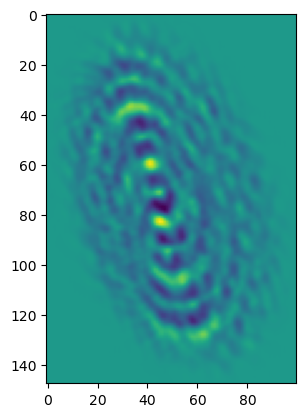

In [ ]:
complex_projections.plot_sum_of_projections(np.angle)

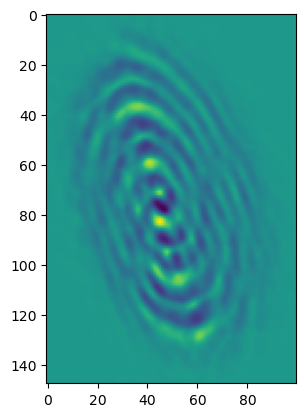

In [ ]:
task.apply_staged_shift()
complex_projections.plot_sum_of_projections(np.angle)

Next:
- Add linear image shifting
- Make it easy to switch between the 16x downsampled and full res images